In [2]:
#A team of researchers from Qatar University, Doha, Qatar, and the University of Dhaka, Bangladesh along with their collaborators from Pakistan and Malaysia in collaboration 
#with medical doctors have created a database of chest X-ray images for COVID-19 positive cases along with Normal and Viral Pneumonia images. 
#This COVID-19, normal, and other lung infection dataset is released in stages. In the first release, we have released 219 COVID-19, 1341 normal, and 1345 viral pneumonia chest X-ray (CXR) 
#images. In the first update, we have increased the COVID-19 class to 1200 CXR images. In the 2nd update, we have increased the database to 3616 COVID-19 positive cases 
#along with 10,192 Normal, 6012 Lung Opacity (Non-COVID lung infection), and 1345 Viral Pneumonia images and corresponding lung masks.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import os


In [4]:
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

In [20]:
result = ['Normal', "COVID"]
path = 'COVID-19_Radiography_Dataset'
data_dir = os.path.join(path)

data = []
for id, level in enumerate(result):
    for file in os.listdir(os.path.join(data_dir, level+'/'+'images')):
        data.append([level +'/' +'images'+ '/'+file, level])

data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])

data['path'] = path + '/' + data['image_file']
data['corona_result'] = data['corona_result'].map({'Normal': 'Negative', 'COVID': 'Positive'})


data.head()

,image_file,corona_result,path
0,Normal/images/Normal-1.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
1,Normal/images/Normal-10.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
2,Normal/images/Normal-100.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
3,Normal/images/Normal-1000.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
4,Normal/images/Normal-10000.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...


In [21]:
print('Number of Duplicated Samples: %d'%(data.duplicated().sum()))
print('Number of Total Samples: %d'%(data.isnull().value_counts()))

Number of Duplicated Samples: 0
Number of Total Samples: 13808


d:\python\odyn\anak2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


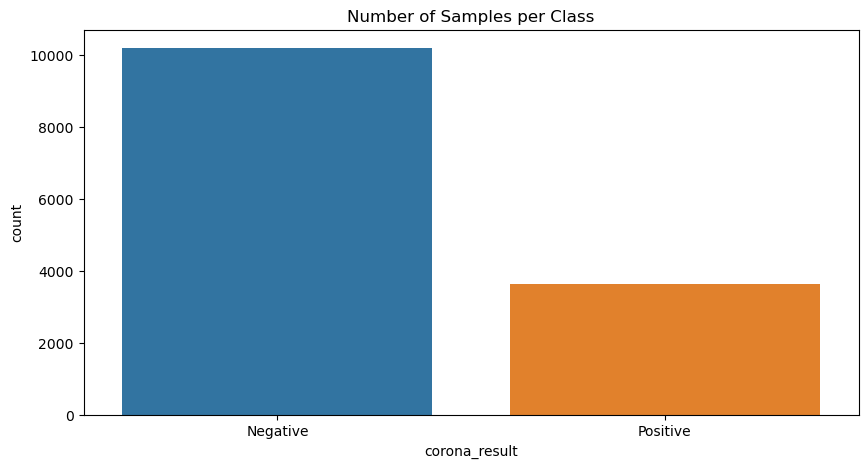

In [22]:
#Data Visualization
plt.figure(figsize=(10,5))
sns.countplot(data['corona_result'])
plt.title('Number of Samples per Class')
plt.show()


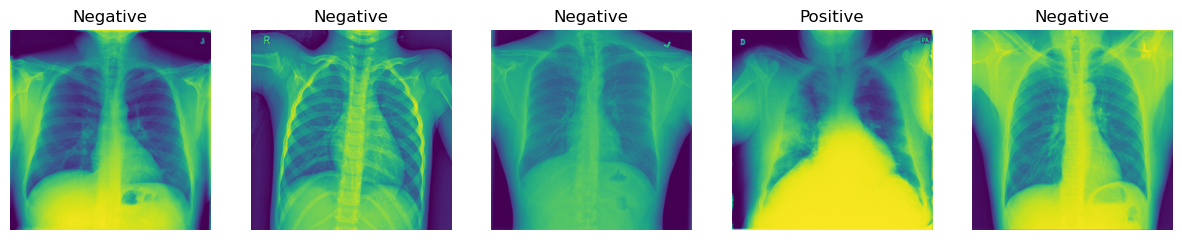

In [39]:
#always random sample images from the dataset 
def random_sample_images(data, n_samples):
    sample = data.sample(n_samples)
    plt.figure(figsize=(15,10))
    for i in range(n_samples):
        plt.subplot(1,n_samples,i+1)
        plt.imshow(plt.imread(sample['path'].iloc[i]))
        plt.title(sample['corona_result'].iloc[i])
        plt.axis('off')
    plt.show()

random_sample_images(data, 5)



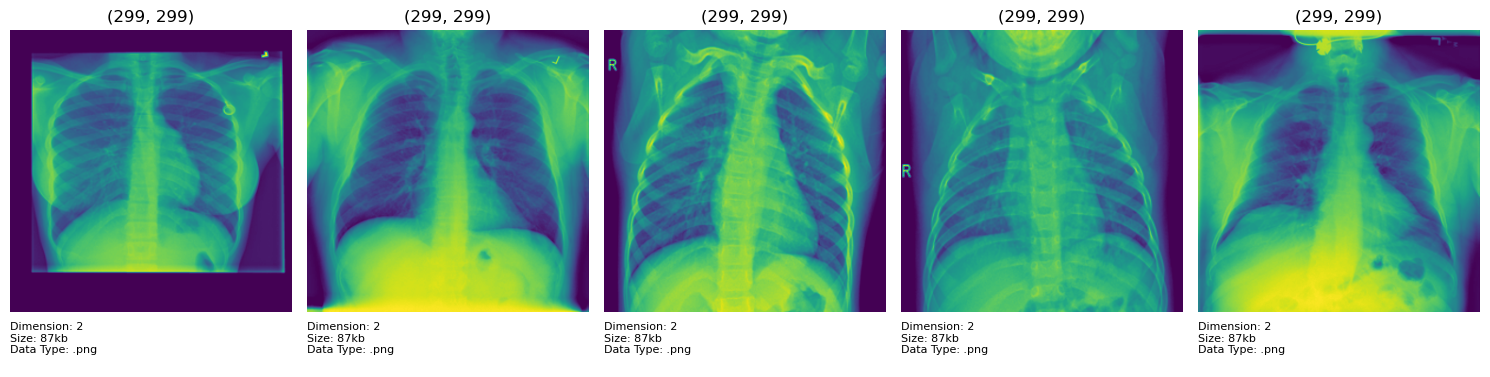

In [52]:
#despription of shape, height, width, dimension, size, data type and channels of the above images
def image_description(data):
    plt.figure(figsize=(15, 10))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        img = plt.imread(data['path'].iloc[i])
        plt.imshow(img)
        plt.title(img.shape)
        plt.axis('off')
        
        # Calculate additional information
        dimension = img.ndim
        size = img.size // 1024  # Convert to kilobytes
        file_extension = os.path.splitext(data['path'].iloc[i])[1]
                
        # Create description string
        description = f"Dimension: {dimension}\nSize: {size}kb\nData Type: {file_extension}\n"
        
        
        # Add text below the image
        plt.text(0, img.shape[0]+10, description,
                 color='black', backgroundcolor='white', fontsize=8, verticalalignment='top')
        
    plt.tight_layout()
    plt.show()

image_description(data)


In [55]:
#ben grahams method
#convert the images to greyscale and then apply Gaussian blur to them
from PIL import Image, ImageOps

def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.convert('L') # convert to grayscale
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    im = ImageOps.equalize(im, mask=None)
    return im

#apply the preprocessing function to all the images
def load_images(df, image_size):
    images = []
    for i, file in enumerate(df['path']):
        if i % 1000 == 0:
            print(f'Processed {i} of {len(df)} images')
        image = preprocess_image(file, desired_size=image_size)
        images.append(np.array(image))
    return images

#load the images
images = load_images(data, 224)

#convert the images to numpy array
images = np.array(images)

#check the shape of the images
images.shape


Processed 0 of 13808 images


C:\Users\Administrator\AppData\Local\Temp\ipykernel_16592\3153197716.py:8: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  im = im.resize((desired_size, )*2, resample=Image.LANCZOS)


Processed 1000 of 13808 images
Processed 2000 of 13808 images
Processed 3000 of 13808 images
Processed 4000 of 13808 images
Processed 5000 of 13808 images
Processed 6000 of 13808 images
Processed 7000 of 13808 images
Processed 8000 of 13808 images
Processed 9000 of 13808 images
Processed 10000 of 13808 images
Processed 11000 of 13808 images
Processed 12000 of 13808 images
Processed 13000 of 13808 images


(13808, 224, 224)

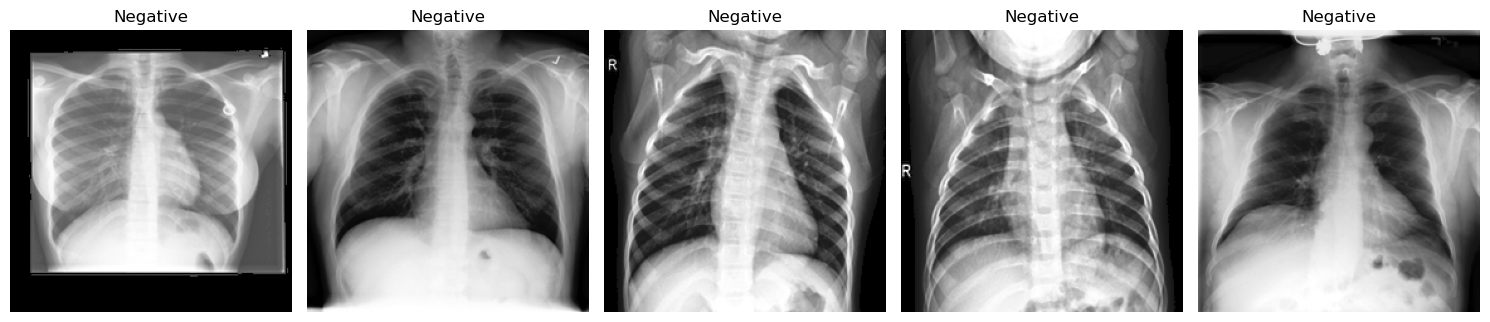

In [58]:
#plot the images after ben grahams method
def plot_images(images, labels):
    plt.figure(figsize=(15, 10))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(images, data['corona_result'])



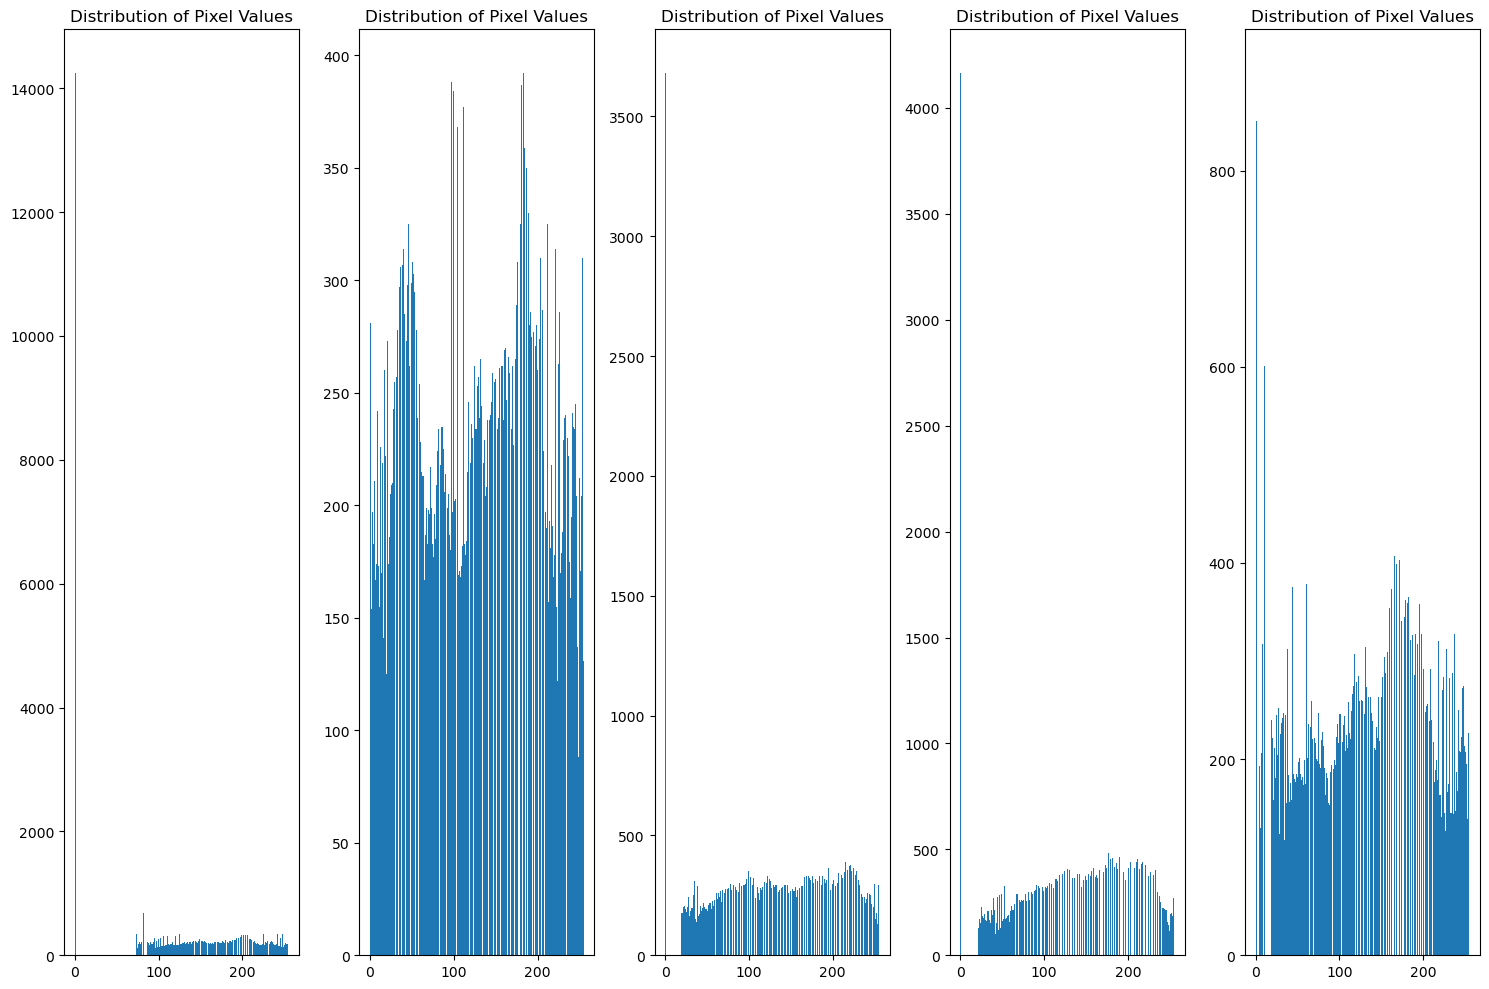

In [59]:
#Image Value Distribution
#plot the distribution of the images
def plot_image_value_distribution(images):
    plt.figure(figsize=(15, 10))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.hist(images[i].ravel(), bins=256)
        plt.title('Distribution of Pixel Values')
    plt.tight_layout()
    plt.show()

plot_image_value_distribution(images)


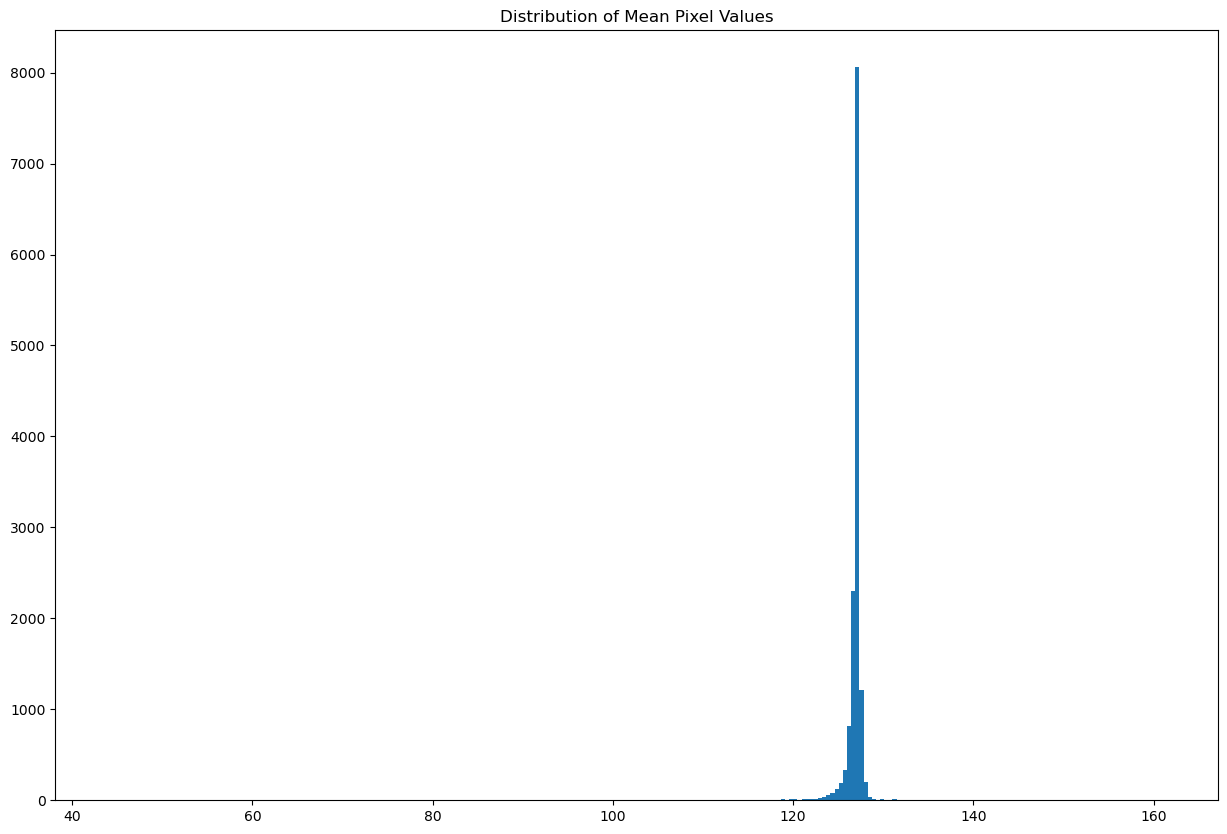

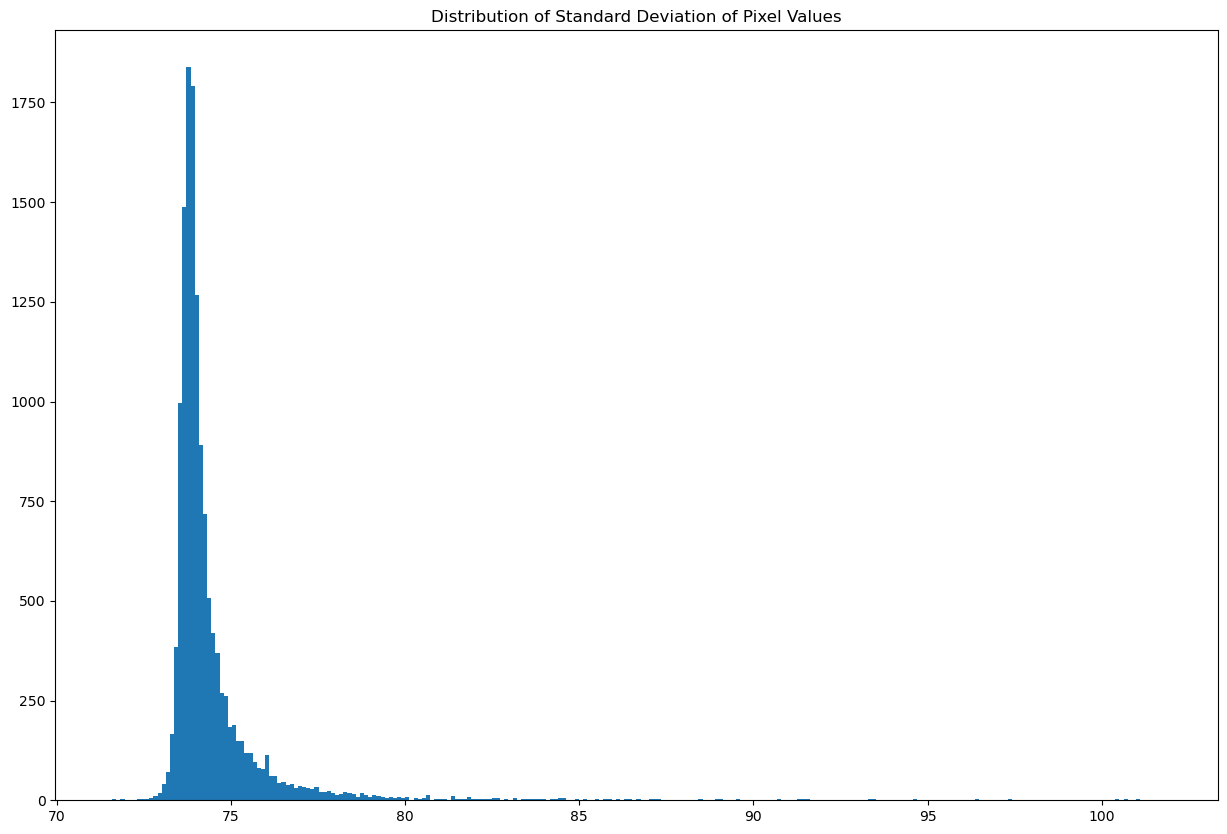

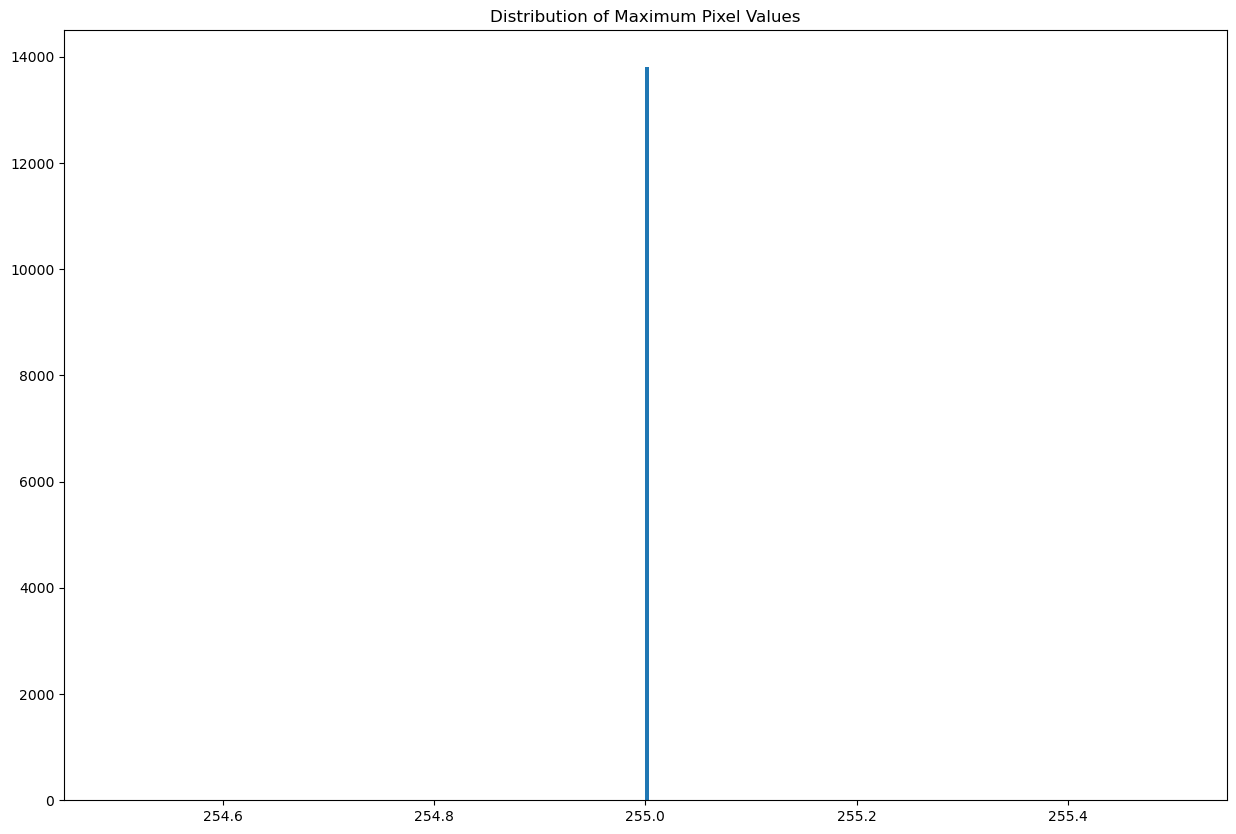

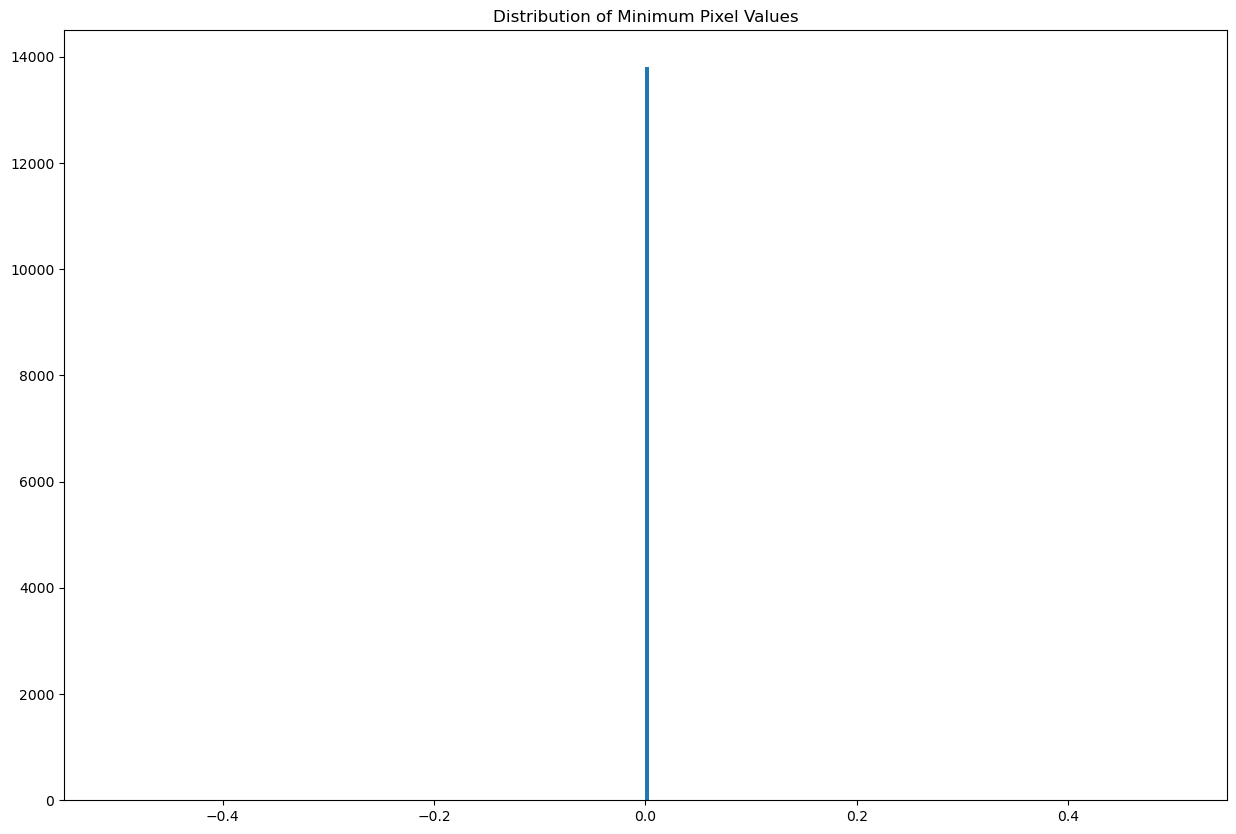

In [60]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(len(images)):
    mean_val.append(np.mean(images[i]))
    std_dev_val.append(np.std(images[i]))
    max_val.append(np.max(images[i]))
    min_val.append(np.min(images[i]))

#plot the mean value of the images
plt.figure(figsize=(15, 10))
plt.hist(mean_val, bins=256)
plt.title('Distribution of Mean Pixel Values')
plt.show()

#plot the standard deviation of the images
plt.figure(figsize=(15, 10))
plt.hist(std_dev_val, bins=256)
plt.title('Distribution of Standard Deviation of Pixel Values')
plt.show()

#plot the maximum value of the images
plt.figure(figsize=(15, 10))
plt.hist(max_val, bins=256)
plt.title('Distribution of Maximum Pixel Values')
plt.show()

#plot the minimum value of the images
plt.figure(figsize=(15, 10))
plt.hist(min_val, bins=256)
plt.title('Distribution of Minimum Pixel Values')
plt.show()





In [65]:
#Data amodelling
#split the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, data['corona_result'], test_size=0.2, random_state=42)



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<Figure size 2000x800 with 0 Axes>